# Лабораторная работа №2. Базы знаний и онтологии

Необходимо разработать программу на языке python, которая реализует предложенное вариантом задание. Предметную область можно выбрать из предложенного списка, либо выбрать свою.


### Общая часть

В рамках данной лабораторной работы необходимо разработать систему управления для автоматизации заданного технического объекта. 
Для хранения базы правил и онтологии предметной области предлагается использовать Neo4j, либо любое другое хранилище на выбор (реляционная СУБД, Protege). Задание предполагает проектирование логической модели управления, построение и настройку правил управления, а также разработку симулятора для проверки работы системы управления. Для формирования условий срабатывания правил необходимо использовать фаззификацию на основе нечеткой логики, для формирования управляющих инструкций - дефаззификацию. 

Также необходимо разработать минимально рабочий симулятор предметной области с дискретным программным управлением.

#### Этапы работы

1. Ознакомиться с особенностями выбранного объекта проектирования, включая его функциональные требования, ограничения и задачи автоматизации.
  
2. Разработка базы данных знаний:
   - Создание онтологии предметной области в базе данных.
   - Формулировка и добавление правил управления объектом, связанных с условиями и действиями.

3. Проектирование логической модели управления:
   - Реализация машины логического вывода для обработки правил.
   - Учет приоритетов и разрешение конфликтов правил при необходимости.

4. Создание симуляции:
   - Построение простой симуляции, которая проверяет выполнение правил и реакции объекта на различные входные условия.
   - Тестирование системы управления в разных сценариях и анализ результатов.

5. Структура отчета:
   - Введение: описание предметной области и задачи автоматизации.
   - Модель базы знаний: описание онтологии и структуры базы Neo4j.
   - Правила управления: список правил, с кратким описанием каждого правила и его логики.
   - Логическая модель управления: описание машины вывода и методов разрешения конфликтов.
   - Симуляция и тестирование: описание симуляции, сценарии тестирования, результаты выполнения.
   - Выводы и заключение: краткие выводы по результатам работы и предложения по улучшению системы.

---

### Варианты заданий
16. Автоматизация паркинга: Реализовать систему для управления местами на паркинге, регулировки въезда и выезда автомобилей.

In [93]:
import random
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from collections import defaultdict
import time

### Введение


В этой работе реализуется система автоматизации многоэтажной парковки (6 этажей, по 10 мест на этаж, первые 3 места на каждом этаже — зарядные).
Цели:
- контроль въезда (на основе заполненности);
- выбор предпочтительного этажа с учётом приоритета и потребности в зарядке;
- размещение автомобиля на слотах;
- симуляция заездов/выездов и визуализация.

# 2. Блок аналитики

In [94]:
class ParkingAnalytics:
    def __init__(self):
        self.stats = {
            'total_cars': 0,
            'parked_cars': 0,
            'rejected_cars': 0,
            'electric_parked': 0,
            'priority_parked': defaultdict(int),
            'floor_distribution': defaultdict(int),
            'charger_utilization': 0,
            'total_wait_time': 0,
            'failed_parking_attempts': 0,
            'successful_exits': 0
        }
        self.car_log = []
        self.waiting_cars = []

    def add_to_waiting(self, car):
        car['wait_start_time'] = time.time()
        car['wait_attempts'] = 0
        self.waiting_cars.append(car)
    
    def update_waiting_time(self, car):
        car['wait_attempts'] = car.get('wait_attempts', 0) + 1
        return car['wait_attempts']
    
    def remove_from_waiting(self, car):
        if car in self.waiting_cars:
            self.waiting_cars.remove(car)
    
    def get_waiting_count(self):
        return len(self.waiting_cars)
    
    def update_stats(self, car, parked, wait_time=0):
        self.stats['total_cars'] += 1
        if parked:
            self.stats['parked_cars'] += 1
            self.stats['total_wait_time'] += wait_time
            if car['is_electric']:
                self.stats['electric_parked'] += 1
            self.stats['priority_parked'][car['priority']] += 1
        else:
            self.stats['rejected_cars'] += 1
            self.stats['failed_parking_attempts'] += 1
        self.car_log.append({
            'car_id': car['id'],
            'electric': car['is_electric'],
            'priority': car['priority'],
            'parked': parked,
            'wait_time': wait_time
        })
    
    def update_floor_stats(self, floor_id):
        self.stats['floor_distribution'][floor_id] += 1
    
    def record_exit(self):
        self.stats['successful_exits'] += 1
    
    def print_report(self, parking_data):
        total_cars = self.stats['total_cars']
        parked_cars = self.stats['parked_cars']
        if total_cars == 0:
            return
        utilization = (parked_cars / total_cars) * 100
        avg_wait_time = self.stats['total_wait_time'] / parked_cars if parked_cars > 0 else 0
        print(f"\n{'='*50}")
        print(f"ДЕТАЛЬНАЯ СТАТИСТИКА ПАРКИНГА")
        print(f"{'='*50}")
        print(f"Всего машин: {total_cars}")
        print(f"Успешно припарковано: {parked_cars} ({utilization:.1f}%)")
        print(f"Отказано в парковке: {self.stats['rejected_cars']}")
        print(f"Неудачных попыток парковки: {self.stats['failed_parking_attempts']}")
        print(f"Успешных выездов: {self.stats['successful_exits']}")
        print(f"Электромобилей припарковано: {self.stats['electric_parked']}")
        print(f"Среднее время ожидания: {avg_wait_time:.1f} тактов")
        print(f"Машин в очереди: {self.get_waiting_count()}")


## 3. Онтология
## Онтология парковки

### 1. Структура парковки
- **Этажи**: `n_floors`
- **Слоты на этаж**: `slots_per_floor`
- **Зарядные станции**: есть на этажах `charger_floors`
- **Состояние слота**:
  - `id` — уникальный идентификатор (например, "1-3" → этаж 1, слот 3)
  - `has_charger` — наличие зарядки
  - `occupied` — занят ли слот
  - `car_id` — идентификатор припаркованной машины
  - `reserved` — зарезервирован ли слот
- **Общие параметры парковки**:
  - `capacity` — общая вместимость (этажи × слоты на этаж)
  - `occupied` — текущее количество занятых слотов
  - `floors` — список этажей со слотами

### 2. Генерация машин
- **Количество машин**: `n`
- **Приоритеты**: распределение `priority_distribution` (по умолчанию {1:0.1, 2:0.2, 3:0.4, 4:0.2, 5:0.1})
- **Тип машины**:
  - Электромобиль с вероятностью `electric_prob`
  - Обычный автомобиль — иначе
- **Свойства машины**:
  - `id` — уникальный идентификатор (например, "C1", "C2")
  - `is_electric` — электрическая или нет
  - `priority` — уровень приоритета (1–5)
  - `arrival_time` — момент появления в очереди на парковку


In [95]:
def create_parking_ontology(n_floors=6, slots_per_floor=10, charger_floors=None):
    if charger_floors is None:
        charger_floors = [1,2,3]
    floors = []
    for f in range(1, n_floors+1):
        floor_slots = []
        for s in range(slots_per_floor):
            has_charger = f in charger_floors and s<3
            floor_slots.append({"id":f"{f}-{s+1}","has_charger":has_charger,"occupied":False,"car_id":None,"reserved":False})
        floors.append({"floor_id":f, "slots":floor_slots})
    return {"capacity":n_floors*slots_per_floor, "occupied":0, "floors":floors}

def generate_cars(n, priority_distribution=None, electric_prob=0.4):
    if priority_distribution is None:
        priority_distribution={1:0.1,2:0.2,3:0.4,4:0.2,5:0.1}
    cars=[]
    for i in range(1,n+1):
        car_type="electric" if random.random()<electric_prob else "regular"
        rand_val=random.random()
        cumulative=0 # накопленная вероятность
        car_priority=3
        for p,prob in priority_distribution.items():
            cumulative += prob
            if rand_val <= cumulative:
                car_priority=p
                break
        cars.append({"id":f"C{i}","is_electric":car_type=="electric","priority":car_priority,"arrival_time":i})
    return cars


## Логическая модель управления парковкой

### 1. Въезд
- **Почти пусто** → въезд разрешён всем
- **Средняя загрузка**:
  - Высокий приоритет → разрешено
  - Средний приоритет → частично разрешено
  - Низкий приоритет → запрещено
- **Почти полная парковка**:
  - Высокий приоритет → частично разрешено
  - Средний и низкий приоритет → запрещено

### 2. Выбор этажа
- **Электромобиль** → этажи с зарядками (1–3)
- **Обычный автомобиль** → остальные этажи (2–4)
- **Высокий приоритет** → ближе к выходу, но не первый этаж
- **Низкий приоритет** → дальше от выхода


In [96]:
def setup_fuzzy_systems():
    occupancy = ctrl.Antecedent(np.arange(0, 101, 1), 'occupancy')
    priority = ctrl.Antecedent(np.arange(1, 7, 1), 'priority')
    entry_permission = ctrl.Consequent(np.arange(0, 101, 1), 'entry_permission')
    
    occupancy['low'] = fuzz.trapmf(occupancy.universe, [0, 0, 20, 40])
    occupancy['medium'] = fuzz.trimf(occupancy.universe, [30, 50, 70])
    occupancy['high'] = fuzz.trapmf(occupancy.universe, [60, 80, 100, 100])
    
    priority['low'] = fuzz.trimf(priority.universe, [1, 1, 3])
    priority['medium'] = fuzz.trimf(priority.universe, [2, 3, 4])
    priority['high'] = fuzz.trimf(priority.universe, [3, 5, 6])
    
    entry_permission['deny'] = fuzz.trapmf(entry_permission.universe, [0, 0, 30, 50])
    entry_permission['limit'] = fuzz.trimf(entry_permission.universe, [40, 55, 70])
    entry_permission['allow'] = fuzz.trapmf(entry_permission.universe, [60, 80, 100, 100])
    
    rules_entry = [
        ctrl.Rule(occupancy['low'], entry_permission['allow']),
        ctrl.Rule(occupancy['medium'] & priority['high'], entry_permission['allow']),
        ctrl.Rule(occupancy['medium'] & priority['medium'], entry_permission['limit']),
        ctrl.Rule(occupancy['medium'] & priority['low'], entry_permission['deny']),
        ctrl.Rule(occupancy['high'] & priority['high'], entry_permission['limit']),
        ctrl.Rule(occupancy['high'] & (priority['medium'] | priority['low']), entry_permission['deny'])
    ]
    
    parking_ctrl = ctrl.ControlSystem(rules_entry)
    
    priority_input = ctrl.Antecedent(np.arange(1, 7, 1), 'priority')
    needs_charge = ctrl.Antecedent(np.arange(0, 2, 1), 'needs_charge')
    preferred_floor = ctrl.Consequent(np.arange(1, 7, 0.1), 'preferred_floor')
    
    priority_input['low'] = fuzz.trimf(priority_input.universe, [1, 1, 2])
    priority_input['medium'] = fuzz.trimf(priority_input.universe, [2, 3, 4])
    priority_input['high'] = fuzz.trimf(priority_input.universe, [3, 4, 6])
    
    needs_charge['no'] = fuzz.trimf(needs_charge.universe, [0, 0, 1])
    needs_charge['yes'] = fuzz.trimf(needs_charge.universe, [0, 1, 1])
    
    preferred_floor['floor1'] = fuzz.trimf(preferred_floor.universe, [1, 1, 2])
    preferred_floor['floor2'] = fuzz.trimf(preferred_floor.universe, [2, 2, 3])
    preferred_floor['floor3'] = fuzz.trimf(preferred_floor.universe, [3, 3, 4])
    preferred_floor['floor4'] = fuzz.trimf(preferred_floor.universe, [4, 4, 5])
    preferred_floor['floor5'] = fuzz.trimf(preferred_floor.universe, [5, 5, 6])
    preferred_floor['floor6'] = fuzz.trimf(preferred_floor.universe, [6, 6, 6])
    
    rules_floor = [
        ctrl.Rule(priority_input['low'] & needs_charge['no'], preferred_floor['floor4']),
        ctrl.Rule(priority_input['medium'] & needs_charge['no'], preferred_floor['floor3']),
        ctrl.Rule(priority_input['high'] & needs_charge['no'], preferred_floor['floor2']),
        ctrl.Rule(priority_input['low'] & needs_charge['yes'], preferred_floor['floor1']),
        ctrl.Rule(priority_input['medium'] & needs_charge['yes'], preferred_floor['floor3']),
        ctrl.Rule(priority_input['high'] & needs_charge['yes'], preferred_floor['floor2']),
    ]
    
    floor_ctrl = ctrl.ControlSystem(rules_floor)
    
    return parking_ctrl, floor_ctrl

PARKING_CTRL, FLOOR_CTRL = setup_fuzzy_systems()

def check_entry(parking_data, car_priority=3):
    total = parking_data["capacity"]
    occupied = parking_data["occupied"]
    occupancy_rate = (occupied / total) * 100

    sim = ctrl.ControlSystemSimulation(PARKING_CTRL)
    sim.input['occupancy'] = occupancy_rate
    sim.input['priority'] = car_priority
    sim.compute()
    
    permission_level = sim.output['entry_permission']
    threshold = 70 - (car_priority * 5)
    return permission_level > max(50, threshold)

def get_preferred_floor(priority, is_electric):
    sim = ctrl.ControlSystemSimulation(FLOOR_CTRL)
    sim.input['priority'] = max(1, min(6, int(priority)))
    sim.input['needs_charge'] = 1 if is_electric else 0
    
    try:
        sim.compute()
        if 'preferred_floor' in sim.output:
            return int(round(sim.output['preferred_floor']))
    except:
        pass
    
    return 3

def find_optimal_slot(car, parking_spots, preferred_floor):
    best_score = -1
    best_slot = None
    
    for floor in parking_spots:
        floor_id = floor['floor_id']
        for slot in floor['slots']:
            if not slot['occupied'] and is_slot_suitable(slot, car, parking_spots):
                score = calculate_slot_score(slot, floor_id, preferred_floor, car)
                if score > best_score:
                    best_score = score
                    best_slot = slot
    
    return best_slot

def is_slot_suitable(slot, car, parking_spots):
    if car['is_electric']:
        if slot['has_charger']:
            return True
        return not any_charger_available(parking_spots)
    return True

def any_charger_available(parking_spots):
    for floor in parking_spots:
        for slot in floor['slots']:
            if slot['has_charger'] and not slot['occupied']:
                return True
    return False

def calculate_slot_score(slot, floor_id, preferred_floor, car):
    if car['is_electric']:
        FLOOR_WEIGHT = 0.3
        CHARGER_WEIGHT = 0.5
        PRIORITY_WEIGHT = 0.2
    else:
        FLOOR_WEIGHT = 0.6
        CHARGER_WEIGHT = 0
        PRIORITY_WEIGHT = 0.4
    
    floor_diff = abs(floor_id - preferred_floor)
    floor_score = 1 / (floor_diff + 1)
    
    charger_score = 1 if (not car['is_electric'] or slot['has_charger']) else 0
    
    priority_score = car['priority'] / 6
    
    return (FLOOR_WEIGHT * floor_score + 
            CHARGER_WEIGHT * charger_score + 
            PRIORITY_WEIGHT * priority_score)

## 5. Парковка машин


In [97]:
def park_car(car, parking_data, analytics):
    parking_spots = parking_data["floors"]
    
    # Обновляем счетчик попыток
    wait_attempts = analytics.update_waiting_time(car)
    
    # Проверка разрешения на въезд (учитываем приоритет и время ожидания)
    if not check_entry(parking_data, car['priority']):
        # Но если машина ждет долго, даем ей приоритет
        if wait_attempts > 3:
            print(f"Car {car['id']}: приоритет по времени ожидания ({wait_attempts} попыток)")
            # Принудительно разрешаем въезд после долгого ожидания
        else:
            print(f"Car {car['id']}: въезд запрещён (заполненность: {parking_data['occupied']}/{parking_data['capacity']}, попытка: {wait_attempts})")
            analytics.update_stats(car, False, wait_attempts)
            return False

    # Определение предпочтительного этажа
    preferred_floor = get_preferred_floor(car['priority'], car['is_electric'])
    
    # Поиск оптимального места
    best_slot = find_optimal_slot(car, parking_spots, preferred_floor)
    
    if best_slot:
        best_slot['occupied'] = True
        best_slot['car_id'] = car['id']
        parking_data["occupied"] += 1
        
        floor_id = int(best_slot['id'].split('-')[0])
        analytics.update_stats(car, True, wait_attempts)
        analytics.update_floor_stats(floor_id)
        analytics.remove_from_waiting(car)
        
        charger_status = "⚡" if best_slot['has_charger'] else " "
        priority_icon = "⭐" * car['priority']
        print(f"Car {car['id']} {priority_icon}: этаж {floor_id}, слот {best_slot['id']} {charger_status}")
        return True
    
    print(f"Car {car['id']}: нет подходящих мест (попытка: {wait_attempts})")
    analytics.update_stats(car, False, wait_attempts)
    return False

# 5. Выезд
def exit_car(car_id, parking_data, analytics):
    for floor in parking_data['floors']:
        for slot in floor['slots']:
            if slot['occupied'] and slot['car_id'] == car_id:
                slot['occupied'] = False
                slot['car_id'] = None
                parking_data["occupied"] -= 1
                analytics.record_exit()
                print(f"Car {car_id} выехала со слота {slot['id']}")
                return True
    return False

def random_exit(parking_data, analytics, probability=0.1):
    exited_count = 0
    all_slots = [slot for floor in parking_data['floors'] for slot in floor['slots']]
    occupied_slots = [s for s in all_slots if s['occupied']]
    
    for slot in occupied_slots:
        if random.random() < probability:
            car_id = slot['car_id']
            slot['occupied'] = False
            slot['car_id'] = None
            parking_data["occupied"] -= 1
            exited_count += 1
            analytics.record_exit()
            print(f"Car {car_id} выехала (случайный выезд)")
    
    return exited_count

## 6. Визуализация парковки в реальном времени

In [98]:

def visualize_parking(parking_spots):
    floors = parking_spots
    n_floors = len(floors)
    
    fig, axes = plt.subplots(n_floors, 1, figsize=(12, n_floors * 1.5))
    if n_floors == 1:
        axes = [axes]
    
    for idx, floor in enumerate(reversed(floors)):
        ax = axes[idx]
        colors = []
        labels = []
        
        for slot in floor['slots']:
            if slot['occupied']:
                colors.append('red')
            else:
                colors.append('green')
            
            if slot['has_charger']:
                labels.append('⚡')
            else:
                labels.append('')
        
        bars = ax.bar(range(len(floor['slots'])), [1] * len(floor['slots']), 
                     color=colors, edgecolor='black', alpha=0.8)
        
        for i, (label, bar) in enumerate(zip(labels, bars)):
            ax.text(i, 0.5, label, ha='center', va='center', 
                   fontsize=10, fontweight='bold')
        
        ax.set_xticks(range(len(floor['slots'])))
        ax.set_yticks([])
        ax.set_title(f"Этаж {floor['floor_id']} ({sum(1 for s in floor['slots'] if s['occupied'])}/{len(floor['slots'])} занято)", 
                    loc='left', fontsize=12)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 7. Симуляция

Запуск улучшенной симуляции парковки...
Параметры симуляции:
  - Всего машин: 100
  - Вместимость парковки: 60
  - Вероятность выезда: 5.0%
  - Максимальное количество попыток: 2

--- Такт 1 ---
Машин в очереди: 0
Новая машина: C1 (приоритет: 2 , электромобиль)
Car C1 ⭐⭐: этаж 3, слот 3-1 ⚡

--- Такт 2 ---
Машин в очереди: 0
Новая машина: C2 (приоритет: 4)
Car C2 ⭐⭐⭐⭐: этаж 2, слот 2-1 ⚡

--- Такт 3 ---
Машин в очереди: 0
Новая машина: C3 (приоритет: 2)
Car C1 выехала (случайный выезд)
Выехало машин: 1
Car C3 ⭐⭐: этаж 3, слот 3-1 ⚡

--- Такт 4 ---
Машин в очереди: 0
Новая машина: C4 (приоритет: 3 , электромобиль)
Car C3 выехала (случайный выезд)
Выехало машин: 1
Car C4 ⭐⭐⭐: этаж 3, слот 3-1 ⚡

--- Такт 5 ---
Машин в очереди: 0
Новая машина: C5 (приоритет: 1 , электромобиль)
Car C5 ⭐: этаж 1, слот 1-1 ⚡

--- Такт 6 ---
Машин в очереди: 0
Новая машина: C6 (приоритет: 2 , электромобиль)
Car C6 ⭐⭐: этаж 3, слот 3-2 ⚡

--- Такт 7 ---
Машин в очереди: 0
Новая машина: C7 (приоритет: 4)
Car C7

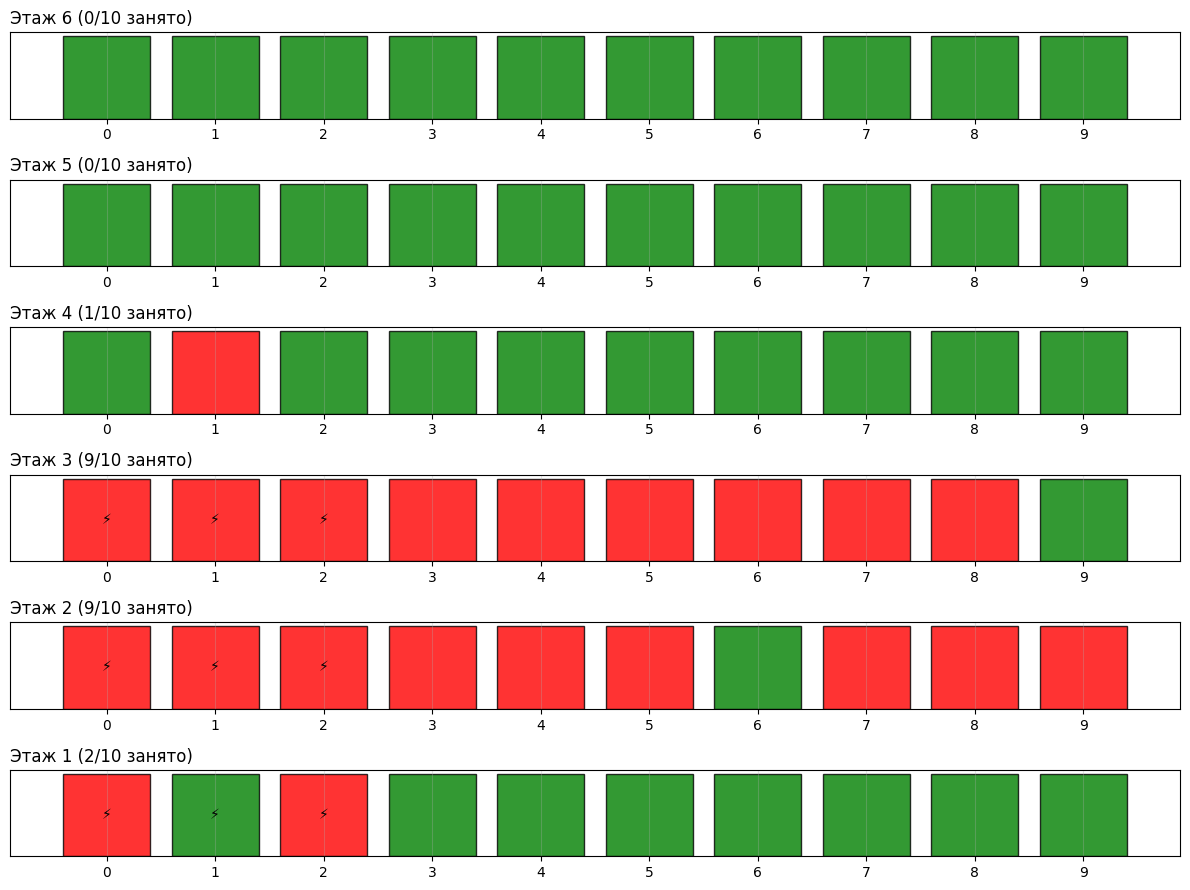


Все машины обработаны!


In [99]:
def run_simulation(total_cars=100, exit_probability=0.1, max_attempts=10):
    print("Запуск улучшенной симуляции парковки...")
    
    # Инициализация
    parking = create_parking_ontology(n_floors=6, slots_per_floor=10)
    analytics = ParkingAnalytics()
    cars = generate_cars(total_cars)
    
    print(f"Параметры симуляции:")
    print(f"  - Всего машин: {total_cars}")
    print(f"  - Вместимость парковки: {parking['capacity']}")
    print(f"  - Вероятность выезда: {exit_probability*100}%")
    print(f"  - Максимальное количество попыток: {max_attempts}")
    
    # Основной цикл симуляции
    parked_cars = 0
    iteration = 0
    
    while analytics.get_waiting_count() > 0 or iteration < len(cars):
        iteration += 1
        print(f"\n--- Такт {iteration} ---")
        print(f"Машин в очереди: {analytics.get_waiting_count()}")
        
        # 1. Добавляем новые машины в очередь
        if iteration <= len(cars):
            new_car = cars[iteration-1]
            analytics.add_to_waiting(new_car)
            print(f"Новая машина: {new_car['id']} (приоритет: {new_car['priority']}"
                    f"{' , электромобиль' if new_car['is_electric'] else ''})")
        
        # 2. Случайные выезды
        exited_count = random_exit(parking, analytics, probability=exit_probability)
        if exited_count > 0:
            print(f"Выехало машин: {exited_count}")
        
        # 3. Пытаемся припарковать машины из очереди
        temp_waiting = analytics.waiting_cars.copy()
        for car in temp_waiting:
            # Проверяем не превысил ли машина лимит попыток
            if 'wait_attempts' in car and car['wait_attempts'] >= max_attempts:
                print(f"Car {car['id']}: ПРЕВЫШЕН ЛИМИТ ПОПЫТОК ({max_attempts}) - машина уезжает")
                analytics.update_stats(car, False, car['wait_attempts'])
                analytics.remove_from_waiting(car)
                continue
                
            if park_car(car, parking, analytics):
                parked_cars += 1
        
        # 4. Условие выхода: все машины обработаны или прошло много времени
        if iteration > total_cars * 2:  # Защита от бесконечного цикла
            print("Достигнут максимальный лимит итераций")
            break
    
    # Финальная статистика
    analytics.print_report(parking)
    visualize_parking(parking['floors'])
    
    # Выводим итоги по очереди
    remaining_waiting = analytics.get_waiting_count()
    if remaining_waiting > 0:
        print(f"\nВ очереди осталось {remaining_waiting} машин")
    else:
        print(f"\nВсе машины обработаны!")
    
    return analytics.stats

def main():
    run_simulation(total_cars=100, exit_probability=0.05, max_attempts=2)
main()

# Итоговый код

Запуск улучшенной симуляции парковки...
Параметры симуляции:
  - Всего машин: 100
  - Вместимость парковки: 60
  - Вероятность выезда: 5.0%
  - Максимальное количество попыток: 2

--- Такт 1 ---
Машин в очереди: 0
Новая машина: C1 (приоритет: 4)
Car C1 ⭐⭐⭐⭐: этаж 2, слот 2-1 ⚡

--- Такт 2 ---
Машин в очереди: 0
Новая машина: C2 (приоритет: 3)
Car C1 выехала (случайный выезд)
Выехало машин: 1
Car C2 ⭐⭐⭐: этаж 3, слот 3-1 ⚡

--- Такт 3 ---
Машин в очереди: 0
Новая машина: C3 (приоритет: 3 , электромобиль)
Car C3 ⭐⭐⭐: этаж 3, слот 3-2 ⚡

--- Такт 4 ---
Машин в очереди: 0
Новая машина: C4 (приоритет: 3)
Car C4 ⭐⭐⭐: этаж 3, слот 3-3 ⚡

--- Такт 5 ---
Машин в очереди: 0
Новая машина: C5 (приоритет: 4)
Car C5 ⭐⭐⭐⭐: этаж 2, слот 2-1 ⚡

--- Такт 6 ---
Машин в очереди: 0
Новая машина: C6 (приоритет: 3 , электромобиль)
Car C4 выехала (случайный выезд)
Выехало машин: 1
Car C6 ⭐⭐⭐: этаж 3, слот 3-3 ⚡

--- Такт 7 ---
Машин в очереди: 0
Новая машина: C7 (приоритет: 2)
Car C7 ⭐⭐: этаж 3, слот 3-4  

-

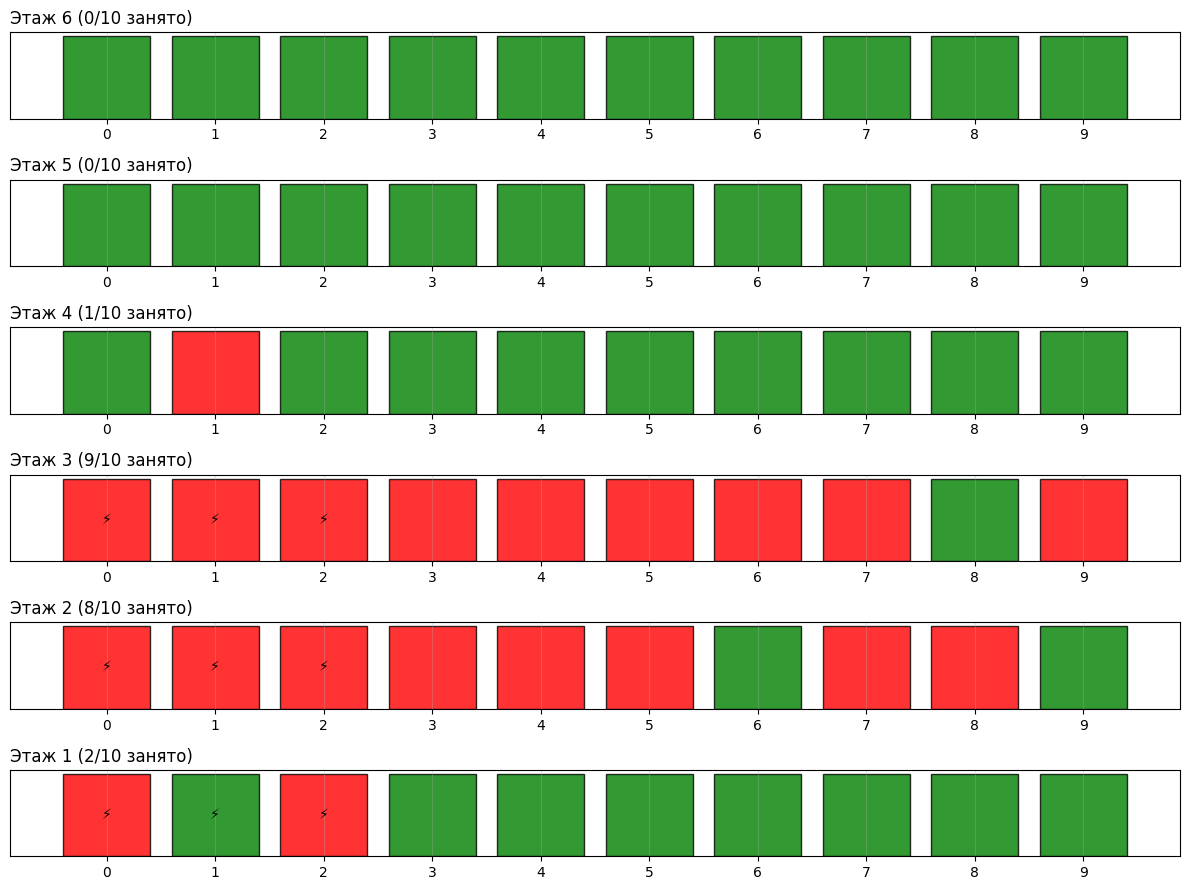


Все машины обработаны!


In [100]:
import random
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from collections import defaultdict
import time

class ParkingAnalytics:
    def __init__(self):
        self.stats = {
            'total_cars': 0,
            'parked_cars': 0,
            'rejected_cars': 0,
            'electric_parked': 0,
            'priority_parked': defaultdict(int),
            'floor_distribution': defaultdict(int),
            'charger_utilization': 0,
            'total_wait_time': 0,
            'failed_parking_attempts': 0,
            'successful_exits': 0
        }
        self.car_log = []
        self.waiting_cars = []  # Машины в очереди ожидания
    
    def add_to_waiting(self, car):
        """Добавить машину в очередь ожидания"""
        car['wait_start_time'] = time.time()
        car['wait_attempts'] = 0
        self.waiting_cars.append(car)
    
    def update_waiting_time(self, car):
        """Обновить счетчик попыток для машины"""
        if 'wait_attempts' not in car:
            car['wait_attempts'] = 0
        car['wait_attempts'] += 1
        return car['wait_attempts']
    
    def remove_from_waiting(self, car):
        """Удалить машину из очереди ожидания"""
        if car in self.waiting_cars:
            self.waiting_cars.remove(car)
    
    def get_waiting_count(self):
        """Получить количество машин в очереди"""
        return len(self.waiting_cars)
    
    def update_stats(self, car, parked, wait_time=0):
        self.stats['total_cars'] += 1
        if parked:
            self.stats['parked_cars'] += 1
            self.stats['total_wait_time'] += wait_time
            if car['is_electric']:
                self.stats['electric_parked'] += 1
            self.stats['priority_parked'][car['priority']] += 1
        else:
            self.stats['rejected_cars'] += 1
            self.stats['failed_parking_attempts'] += 1
        
        self.car_log.append({
            'car_id': car['id'],
            'electric': car['is_electric'],
            'priority': car['priority'],
            'parked': parked,
            'wait_time': wait_time
        })
    
    def update_floor_stats(self, floor_id):
        self.stats['floor_distribution'][floor_id] += 1
    
    def record_exit(self):
        """Зафиксировать успешный выезд"""
        self.stats['successful_exits'] += 1
    
    def print_report(self, parking_data):
        total_cars = self.stats['total_cars']
        parked_cars = self.stats['parked_cars']
        
        if total_cars == 0:
            return
            
        utilization = (parked_cars / total_cars) * 100
        avg_wait_time = self.stats['total_wait_time'] / parked_cars if parked_cars > 0 else 0
        
        print(f"\n{'='*50}")
        print(f"ДЕТАЛЬНАЯ СТАТИСТИКА ПАРКИНГА")
        print(f"{'='*50}")
        print(f"Всего машин: {total_cars}")
        print(f"Успешно припарковано: {parked_cars} ({utilization:.1f}%)")
        print(f"Отказано в парковке: {self.stats['rejected_cars']}")
        print(f"Неудачных попыток парковки: {self.stats['failed_parking_attempts']}")
        print(f"Успешных выездов: {self.stats['successful_exits']}")
        print(f"Электромобилей припарковано: {self.stats['electric_parked']}")
        print(f"Среднее время ожидания: {avg_wait_time:.1f} тактов")
        print(f"Машин в очереди: {self.get_waiting_count()}")
        
        print(f"\nРаспределение по приоритетам:")
        for priority in sorted(self.stats['priority_parked'].keys()):
            count = self.stats['priority_parked'][priority]
            print(f"   Приоритет {priority}: {count} машин")
        
        print(f"\nРаспределение по этажам:")
        for floor_id in sorted(self.stats['floor_distribution'].keys()):
            count = self.stats['floor_distribution'][floor_id]
            print(f"   Этаж {floor_id}: {count} машин")
        
        # Статистика по зарядным станциям
        charger_slots = sum(1 for floor in parking_data['floors'] for slot in floor['slots'] if slot['has_charger'])
        occupied_chargers = sum(1 for floor in parking_data['floors'] for slot in floor['slots'] 
                              if slot['has_charger'] and slot['occupied'])
        if charger_slots > 0:
            charger_util = (occupied_chargers / charger_slots) * 100
            print(f"Использование зарядок: {occupied_chargers}/{charger_slots} ({charger_util:.1f}%)")

# 1. Онтология парковки
def create_parking_ontology(n_floors=6, slots_per_floor=10, charger_floors=None):
    if charger_floors is None:
        charger_floors = [1, 2, 3]
    
    floors = []
    for f in range(1, n_floors + 1):
        floor_slots = []
        for s in range(slots_per_floor):
            has_charger = f in charger_floors and s < 3
            floor_slots.append({
                "id": f"{f}-{s+1}",
                "has_charger": has_charger,
                "occupied": False,
                "car_id": None,
                "reserved": False
            })
        floors.append({
            "floor_id": f,
            "slots": floor_slots
        })
    
    return {
        "capacity": n_floors * slots_per_floor,
        "occupied": 0,
        "floors": floors
    }

# 2. Генерация машин
def generate_cars(n, priority_distribution=None, electric_prob=0.4):
    if priority_distribution is None:
        priority_distribution = {1: 0.1, 2: 0.2, 3: 0.4, 4: 0.2, 5: 0.1}
    
    cars = []
    for i in range(1, n + 1):
        car_type = "electric" if random.random() < electric_prob else "regular"
        
        rand_val = random.random()
        cumulative = 0
        car_priority = 3
        for priority, prob in priority_distribution.items():
            cumulative += prob
            if rand_val <= cumulative:
                car_priority = priority
                break
        
        cars.append({
            "id": f"C{i}", 
            "is_electric": car_type == "electric", 
            "priority": car_priority,
            "arrival_time": i
        })
    return cars

# 3. Фаззи-контроль
def setup_fuzzy_systems():
    occupancy = ctrl.Antecedent(np.arange(0, 101, 1), 'occupancy')
    priority = ctrl.Antecedent(np.arange(1, 7, 1), 'priority')
    entry_permission = ctrl.Consequent(np.arange(0, 101, 1), 'entry_permission')
    
    occupancy['low'] = fuzz.trapmf(occupancy.universe, [0, 0, 20, 40])
    occupancy['medium'] = fuzz.trimf(occupancy.universe, [30, 50, 70])
    occupancy['high'] = fuzz.trapmf(occupancy.universe, [60, 80, 100, 100])
    
    priority['low'] = fuzz.trimf(priority.universe, [1, 1, 3])
    priority['medium'] = fuzz.trimf(priority.universe, [2, 3, 4])
    priority['high'] = fuzz.trimf(priority.universe, [3, 5, 6])
    
    entry_permission['deny'] = fuzz.trapmf(entry_permission.universe, [0, 0, 30, 50])
    entry_permission['limit'] = fuzz.trimf(entry_permission.universe, [40, 55, 70])
    entry_permission['allow'] = fuzz.trapmf(entry_permission.universe, [60, 80, 100, 100])
    
    rules_entry = [
        ctrl.Rule(occupancy['low'], entry_permission['allow']),
        ctrl.Rule(occupancy['medium'] & priority['high'], entry_permission['allow']),
        ctrl.Rule(occupancy['medium'] & priority['medium'], entry_permission['limit']),
        ctrl.Rule(occupancy['medium'] & priority['low'], entry_permission['deny']),
        ctrl.Rule(occupancy['high'] & priority['high'], entry_permission['limit']),
        ctrl.Rule(occupancy['high'] & (priority['medium'] | priority['low']), entry_permission['deny'])
    ]
    
    parking_ctrl = ctrl.ControlSystem(rules_entry)
    
    priority_input = ctrl.Antecedent(np.arange(1, 7, 1), 'priority')
    needs_charge = ctrl.Antecedent(np.arange(0, 2, 1), 'needs_charge')
    preferred_floor = ctrl.Consequent(np.arange(1, 7, 0.1), 'preferred_floor')
    
    priority_input['low'] = fuzz.trimf(priority_input.universe, [1, 1, 2])
    priority_input['medium'] = fuzz.trimf(priority_input.universe, [2, 3, 4])
    priority_input['high'] = fuzz.trimf(priority_input.universe, [3, 4, 6])
    
    needs_charge['no'] = fuzz.trimf(needs_charge.universe, [0, 0, 1])
    needs_charge['yes'] = fuzz.trimf(needs_charge.universe, [0, 1, 1])
    
    preferred_floor['floor1'] = fuzz.trimf(preferred_floor.universe, [1, 1, 2])
    preferred_floor['floor2'] = fuzz.trimf(preferred_floor.universe, [2, 2, 3])
    preferred_floor['floor3'] = fuzz.trimf(preferred_floor.universe, [3, 3, 4])
    preferred_floor['floor4'] = fuzz.trimf(preferred_floor.universe, [4, 4, 5])
    preferred_floor['floor5'] = fuzz.trimf(preferred_floor.universe, [5, 5, 6])
    preferred_floor['floor6'] = fuzz.trimf(preferred_floor.universe, [6, 6, 6])
    
    rules_floor = [
        ctrl.Rule(priority_input['low'] & needs_charge['no'], preferred_floor['floor4']),
        ctrl.Rule(priority_input['medium'] & needs_charge['no'], preferred_floor['floor3']),
        ctrl.Rule(priority_input['high'] & needs_charge['no'], preferred_floor['floor2']),
        ctrl.Rule(priority_input['low'] & needs_charge['yes'], preferred_floor['floor1']),
        ctrl.Rule(priority_input['medium'] & needs_charge['yes'], preferred_floor['floor3']),
        ctrl.Rule(priority_input['high'] & needs_charge['yes'], preferred_floor['floor2']),
    ]
    
    floor_ctrl = ctrl.ControlSystem(rules_floor)
    
    return parking_ctrl, floor_ctrl

PARKING_CTRL, FLOOR_CTRL = setup_fuzzy_systems()

def check_entry(parking_data, car_priority=3):
    total = parking_data["capacity"]
    occupied = parking_data["occupied"]
    occupancy_rate = (occupied / total) * 100

    sim = ctrl.ControlSystemSimulation(PARKING_CTRL)
    sim.input['occupancy'] = occupancy_rate
    sim.input['priority'] = car_priority
    sim.compute()
    
    permission_level = sim.output['entry_permission']
    threshold = 70 - (car_priority * 5)
    return permission_level > max(50, threshold)

def get_preferred_floor(priority, is_electric):
    sim = ctrl.ControlSystemSimulation(FLOOR_CTRL)
    sim.input['priority'] = max(1, min(6, int(priority)))
    sim.input['needs_charge'] = 1 if is_electric else 0
    
    try:
        sim.compute()
        if 'preferred_floor' in sim.output:
            return int(round(sim.output['preferred_floor']))
    except:
        pass
    
    return 3

def find_optimal_slot(car, parking_spots, preferred_floor):
    best_score = -1
    best_slot = None
    
    for floor in parking_spots:
        floor_id = floor['floor_id']
        for slot in floor['slots']:
            if not slot['occupied'] and is_slot_suitable(slot, car, parking_spots):
                score = calculate_slot_score(slot, floor_id, preferred_floor, car)
                if score > best_score:
                    best_score = score
                    best_slot = slot
    
    return best_slot

def is_slot_suitable(slot, car, parking_spots):
    if car['is_electric']:
        if slot['has_charger']:
            return True
        return not any_charger_available(parking_spots)
    return True

def any_charger_available(parking_spots):
    for floor in parking_spots:
        for slot in floor['slots']:
            if slot['has_charger'] and not slot['occupied']:
                return True
    return False

def calculate_slot_score(slot, floor_id, preferred_floor, car):
    if car['is_electric']:
        FLOOR_WEIGHT = 0.3
        CHARGER_WEIGHT = 0.5
        PRIORITY_WEIGHT = 0.2
    else:
        FLOOR_WEIGHT = 0.6
        CHARGER_WEIGHT = 0
        PRIORITY_WEIGHT = 0.4
    
    floor_diff = abs(floor_id - preferred_floor)
    floor_score = 1 / (floor_diff + 1)
    
    charger_score = 1 if (not car['is_electric'] or slot['has_charger']) else 0
    
    priority_score = car['priority'] / 6
    
    return (FLOOR_WEIGHT * floor_score + 
            CHARGER_WEIGHT * charger_score + 
            PRIORITY_WEIGHT * priority_score)

# 4. Парковка
def park_car(car, parking_data, analytics):
    parking_spots = parking_data["floors"]
    
    # Обновляем счетчик попыток
    wait_attempts = analytics.update_waiting_time(car)
    
    # Проверка разрешения на въезд (учитываем приоритет и время ожидания)
    if not check_entry(parking_data, car['priority']):
        # Но если машина ждет долго, даем ей приоритет
        if wait_attempts > 3:
            print(f"Car {car['id']}: приоритет по времени ожидания ({wait_attempts} попыток)")
            # Принудительно разрешаем въезд после долгого ожидания
        else:
            print(f"Car {car['id']}: въезд запрещён (заполненность: {parking_data['occupied']}/{parking_data['capacity']}, попытка: {wait_attempts})")
            analytics.update_stats(car, False, wait_attempts)
            return False

    # Определение предпочтительного этажа
    preferred_floor = get_preferred_floor(car['priority'], car['is_electric'])
    
    # Поиск оптимального места
    best_slot = find_optimal_slot(car, parking_spots, preferred_floor)
    
    if best_slot:
        best_slot['occupied'] = True
        best_slot['car_id'] = car['id']
        parking_data["occupied"] += 1
        
        floor_id = int(best_slot['id'].split('-')[0])
        analytics.update_stats(car, True, wait_attempts)
        analytics.update_floor_stats(floor_id)
        analytics.remove_from_waiting(car)
        
        charger_status = "⚡" if best_slot['has_charger'] else " "
        priority_icon = "⭐" * car['priority']
        print(f"Car {car['id']} {priority_icon}: этаж {floor_id}, слот {best_slot['id']} {charger_status}")
        return True
    
    print(f"Car {car['id']}: нет подходящих мест (попытка: {wait_attempts})")
    analytics.update_stats(car, False, wait_attempts)
    return False

# 5. Выезд
def exit_car(car_id, parking_data, analytics):
    for floor in parking_data['floors']:
        for slot in floor['slots']:
            if slot['occupied'] and slot['car_id'] == car_id:
                slot['occupied'] = False
                slot['car_id'] = None
                parking_data["occupied"] -= 1
                analytics.record_exit()
                print(f"Car {car_id} выехала со слота {slot['id']}")
                return True
    return False

def random_exit(parking_data, analytics, probability=0.1):
    exited_count = 0
    all_slots = [slot for floor in parking_data['floors'] for slot in floor['slots']]
    occupied_slots = [s for s in all_slots if s['occupied']]
    
    for slot in occupied_slots:
        if random.random() < probability:
            car_id = slot['car_id']
            slot['occupied'] = False
            slot['car_id'] = None
            parking_data["occupied"] -= 1
            exited_count += 1
            analytics.record_exit()
            print(f"Car {car_id} выехала (случайный выезд)")
    
    return exited_count

# 6. Визуализация
def visualize_parking(parking_spots):
    floors = parking_spots
    n_floors = len(floors)
    
    fig, axes = plt.subplots(n_floors, 1, figsize=(12, n_floors * 1.5))
    if n_floors == 1:
        axes = [axes]
    
    for idx, floor in enumerate(reversed(floors)):
        ax = axes[idx]
        colors = []
        labels = []
        
        for slot in floor['slots']:
            if slot['occupied']:
                colors.append('red')
            else:
                colors.append('green')
            
            if slot['has_charger']:
                labels.append('⚡')
            else:
                labels.append('')
        
        bars = ax.bar(range(len(floor['slots'])), [1] * len(floor['slots']), 
                     color=colors, edgecolor='black', alpha=0.8)
        
        for i, (label, bar) in enumerate(zip(labels, bars)):
            ax.text(i, 0.5, label, ha='center', va='center', 
                   fontsize=10, fontweight='bold')
        
        ax.set_xticks(range(len(floor['slots'])))
        ax.set_yticks([])
        ax.set_title(f"Этаж {floor['floor_id']} ({sum(1 for s in floor['slots'] if s['occupied'])}/{len(floor['slots'])} занято)", 
                    loc='left', fontsize=12)
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Симуляция
def run_simulation(total_cars=100, exit_probability=0.1, max_attempts=10):
    print("Запуск улучшенной симуляции парковки...")
    
    # Инициализация
    parking = create_parking_ontology(n_floors=6, slots_per_floor=10)
    analytics = ParkingAnalytics()
    cars = generate_cars(total_cars)
    
    print(f"Параметры симуляции:")
    print(f"  - Всего машин: {total_cars}")
    print(f"  - Вместимость парковки: {parking['capacity']}")
    print(f"  - Вероятность выезда: {exit_probability*100}%")
    print(f"  - Максимальное количество попыток: {max_attempts}")
    
    # Основной цикл симуляции
    parked_cars = 0
    iteration = 0
    
    while analytics.get_waiting_count() > 0 or iteration < len(cars):
        iteration += 1
        print(f"\n--- Такт {iteration} ---")
        print(f"Машин в очереди: {analytics.get_waiting_count()}")
        
        # 1. Добавляем новые машины в очередь
        if iteration <= len(cars):
            new_car = cars[iteration-1]
            analytics.add_to_waiting(new_car)
            print(f"Новая машина: {new_car['id']} (приоритет: {new_car['priority']}"
                    f"{' , электромобиль' if new_car['is_electric'] else ''})")
        
        # 2. Случайные выезды
        exited_count = random_exit(parking, analytics, probability=exit_probability)
        if exited_count > 0:
            print(f"Выехало машин: {exited_count}")
        
        # 3. Пытаемся припарковать машины из очереди
        temp_waiting = analytics.waiting_cars.copy()
        for car in temp_waiting:
            # Проверяем не превысил ли машина лимит попыток
            if 'wait_attempts' in car and car['wait_attempts'] >= max_attempts:
                print(f"Car {car['id']}: ПРЕВЫШЕН ЛИМИТ ПОПЫТОК ({max_attempts}) - машина уезжает")
                analytics.update_stats(car, False, car['wait_attempts'])
                analytics.remove_from_waiting(car)
                continue
                
            if park_car(car, parking, analytics):
                parked_cars += 1
        
        # 4. Условие выхода: все машины обработаны или прошло много времени
        if iteration > total_cars * 2:  # Защита от бесконечного цикла
            print("Достигнут максимальный лимит итераций")
            break
    
    # Финальная статистика
    analytics.print_report(parking)
    visualize_parking(parking['floors'])
    
    # Выводим итоги по очереди
    remaining_waiting = analytics.get_waiting_count()
    if remaining_waiting > 0:
        print(f"\nВ очереди осталось {remaining_waiting} машин")
    else:
        print(f"\nВсе машины обработаны!")
    
    return analytics.stats

def main():
    run_simulation(total_cars=100, exit_probability=0.05, max_attempts=2)
main()